# STEP 0. Import

In [1]:
import os
import zipfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<br/>
<br/>
<br/>
<br/>

# STEP 1. Load Dataset

In [2]:
# 코드를 실행하세요.
# 데이터 다운로드 및 압축 풀기
url = 'https://storage.googleapis.com/download.tensorflow.org/data/rps.zip'
urllib.request.urlretrieve(url, 'rps.zip')
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/')
zip_ref.close()

In [3]:
# 코드를 실행하세요.
# data/rps 경로의 파일 확인
os.listdir('data/rps/')

['paper', 'rock', 'scissors']

In [4]:
# 코드를 실행하세요.
# scissors 폴더의 첫 번째 데이터 경로
sample_data_dir = f"data/rps/scissors/{os.listdir('data/rps/scissors')[0]}"
sample_data_dir

'data/rps/scissors/scissors01-000.png'

In [5]:
# 코드를 실행하세요.
# sample_data를 로드하세요.
from tensorflow.keras.preprocessing.image import load_img, img_to_array
sample_data = load_img(sample_data_dir, target_size=(150, 150))
sample_data = img_to_array(sample_data) / 255

# sample_data의 shape와 첫 번째 픽셀을 출력하세요.
sample_data.shape, sample_data[0, 0, :]

((150, 150, 3), array([0.99607843, 0.99607843, 0.99607843], dtype=float32))

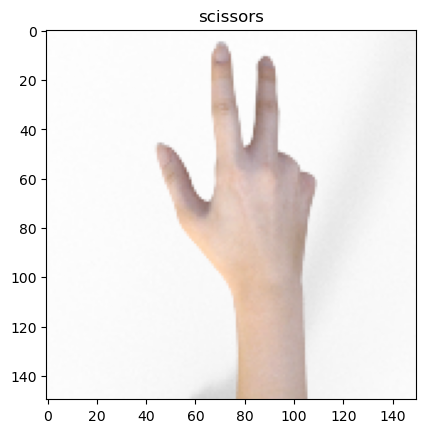

In [6]:
# sample_data를 시각화하세요.
plt.imshow(sample_data)
plt.title('scissors')

plt.show()

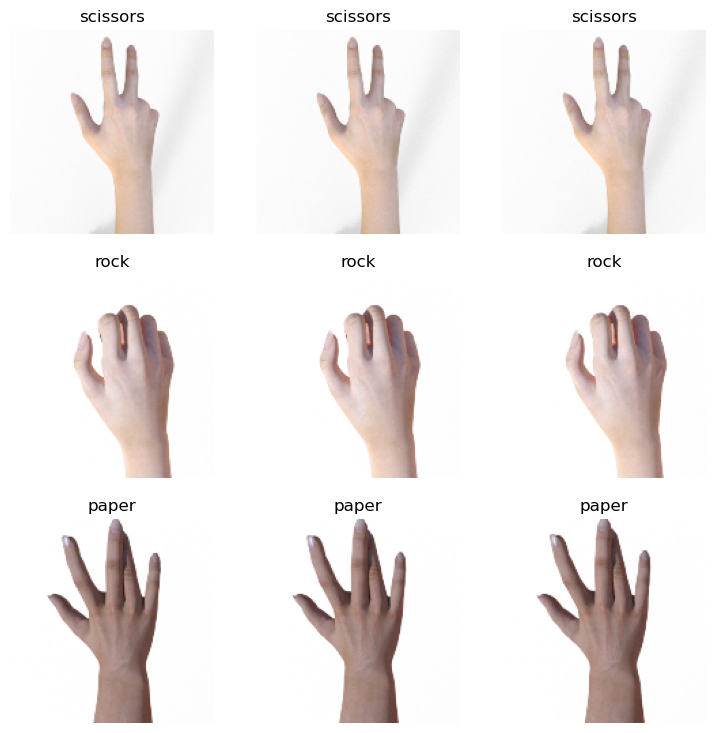

In [7]:
# 코드를 실행하세요.
# 'scissors', 'rock', 'paper'의 각 이미지 3개씩 subplot 하세요.
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.figure(figsize = (9,9))

for i, c in enumerate(['scissors', 'rock', 'paper']) :
    files = os.listdir(f'data/rps/{c}')[:3]
    for j, file in enumerate(files) :
        plt.subplot(3,3, 3*i + j + 1)

        # 이미지 로드
        image = load_img(f'data/rps/{c}/{file}', target_size=(150, 150))
        image = img_to_array(image) / 255
        
        # plot
        plt.imshow(image)
        plt.axis(False)
        plt.title(c)
plt.show()

<br/>
<br/>
<br/>
<br/>

# STEP 2. 전처리 (ImageDataGenerator)
`ImageDataGenerator`를 정의합니다.

다음의 옵션 값들로 Image Aumentation(이미지 변형) 옵션을 적절히 조절해 주세요

* `rescale`: 이미지의 픽셀 값을 조정
* `rotation_range`: 이미지 회전
* `width_shift_range`: 가로 방향으로 이동
* `height_shift_range`: 세로 방향으로 이동
* `shear_range`: 이미지 굴절
* `zoom_range`: 이미지 확대
* `horizontal_flip`: 횡 방향으로 이미지 반전
* `fill_mode`: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
* `validation_split`: validation set의 구성 비율

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 나머지 옵션은 자유롭게 사용하고 validation_split은 0.2로 지정하세요.
training_datagen = ImageDataGenerator(
      rescale=1./255,  # 0~1사이로 변환
      rotation_range=20,  
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      vertical_flip = True,
      fill_mode='nearest',
      validation_split=0.2)

ImageDataGenerator를 잘 만들어 주었다면, `flow_from_directory`로 이미지를 어떻게 공급해 줄 것인가를 지정해 주어야합니다.

* train / validation set 전용 generator를 별도로 정의합니다.
* `batch_size`를 정의합니다 (128)
* `target_size`를 정의합니다. (150 x 150). 이미지를 알아서 타겟 사이즈 만큼 잘라내어 공급합니다.
* `class_mode`는 3개 이상의 클래스인 경우 'categorical' 이진 분류의 경우 `binary`를 지정합니다.
* `subset`을 지정합니다. (training / validation)


In [9]:
# training_generator 생성 (subset='training')
training_generator = training_datagen.flow_from_directory(
        os.path.join('data/rps/'), # 타깃 디렉터리
        target_size=(150, 150),# 모든 이미지의 크기를 150 × 150로 변경
        batch_size=128,
        class_mode='sparse')

Found 2520 images belonging to 3 classes.


In [10]:
# validation_generator 생성 (subset='validation')
validation_generator = training_datagen.flow_from_directory(
        os.path.join('data/rps/'), # 타깃 디렉터리
        target_size=(150, 150),# 모든 이미지의 크기를 150 × 150로 변경
        batch_size=128,
        class_mode='sparse',
        subset='validation')

Found 504 images belonging to 3 classes.


<br/>
<br/>
<br/>
<br/>

# STEP 3. 모델 정의 (Sequential)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential

In [12]:
model = Sequential([
    tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation=tf.nn.relu ),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)

])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 147968)            0

<br/>
<br/>
<br/>
<br/>

# STEP 4. 컴파일 (compile)

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

<br/>
<br/>
<br/>
<br/>

# STEP 5. ModelCheckpoint 생성


In [14]:
# 코드를 실행하세요.
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

<br/>
<br/>
<br/>
<br/>

# STEP 6. 학습 (fit)

In [18]:
history = model.fit(
      training_generator,
      steps_per_epoch=16,
      epochs=25,
      validation_data=validation_generator,
      validation_steps=3,
      callbacks=checkpoint,
      verbose=1)

Epoch 1/25
16/16 [==============================] - 59s 2s/step - loss: 2.4245 - accuracy: 0.3307 - val_loss: 1.1076 - val_accuracy: 0.3411

Epoch 00001: val_loss improved from inf to 1.10762, saving model to tmp_checkpoint.ckpt
Epoch 2/25
16/16 [==============================] - 16s 943ms/step - loss: 1.0888 - accuracy: 0.3875 - val_loss: 1.0707 - val_accuracy: 0.3359

Epoch 00002: val_loss improved from 1.10762 to 1.07068, saving model to tmp_checkpoint.ckpt
Epoch 3/25
16/16 [==============================] - 15s 931ms/step - loss: 1.0788 - accuracy: 0.3887 - val_loss: 1.0524 - val_accuracy: 0.5859

Epoch 00003: val_loss improved from 1.07068 to 1.05237, saving model to tmp_checkpoint.ckpt
Epoch 4/25
16/16 [==============================] - 15s 950ms/step - loss: 1.0490 - accuracy: 0.4696 - val_loss: 1.0531 - val_accuracy: 0.3698

Epoch 00004: val_loss did not improve from 1.05237
Epoch 5/25
16/16 [==============================] - 16s 957ms/step - loss: 1.0289 - accuracy: 0.4888 - v

<br/>
<br/>
<br/>
<br/>

# STEP 7. 결과 확인

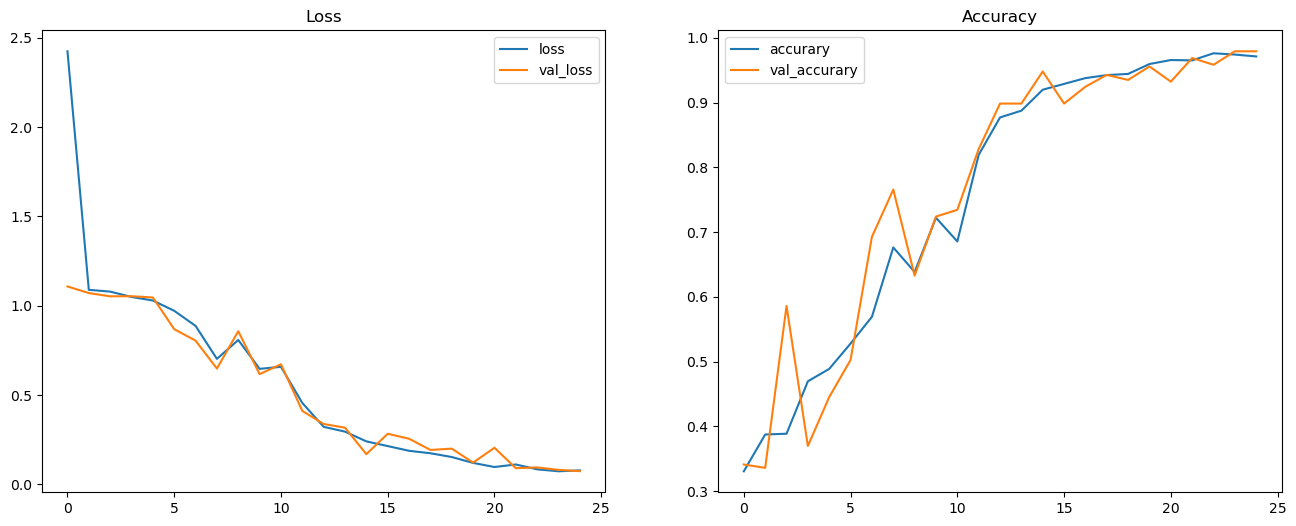

In [27]:
# Epoch 별 Loss와 Accuracy를 시각화하세요.
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)

plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)

plt.title('Accuracy')
plt.plot(history.history['accuracy'],  label="accurary")
plt.plot(history.history['val_accuracy'], label="val_accurary")
plt.legend()

plt.show()

In [28]:
# 코드를 실행하세요. (label 정보)
indices = training_generator.class_indices
indices = {value : key for key, value in indices.items()}
indices

{0: 'paper', 1: 'rock', 2: 'scissors'}

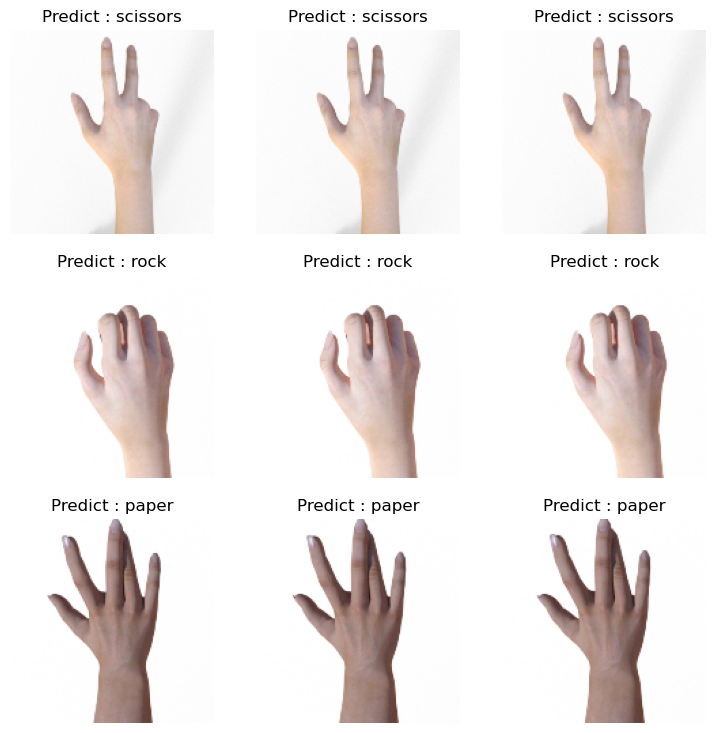

In [29]:
# 코드를 실행하세요.
# step1의 subplot에서 title을 예측 결과로 설정하세요.
# 이미지 로드 후 shape를 (-1,150,150,3)으로 변경해야 model.predict 가 가능합니다.
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.figure(figsize = (9,9))

for i, c in enumerate(['scissors', 'rock', 'paper']) :
    files = os.listdir(f'data/rps/{c}')[:3]
    for j, file in enumerate(files) :
        plt.subplot(3,3, 3*i + j + 1)

        # 이미지 로드
        image = load_img(f'data/rps/{c}/{file}', target_size=(150, 150))
        image = img_to_array(image) / 255
        
        # plot
        plt.imshow(image)
        plt.axis(False)
        plt.title(f'Predict : {indices[model.predict(image.reshape(-1,150,150,3)).argmax()]}')
plt.show()